In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from pytrends.request import TrendReq

# lookup table

In [2]:
lookup = [
    ['N', 'S', 'SS','S', 'N'],
    ['B', 'N', 'S', 'SS','S'],
    ['SB','B', 'N', 'S', 'SS'],
    ['B', 'SB','B', 'N', 'S'],
    ['N', 'B', 'SB','B', 'N']
]
lookup = pd.DataFrame(lookup, index=[5,4,3,2,1], columns=[5,4,3,2,1])
lookup.index.name = 'gtrend'
lookup.columns.name = 'p'; lookup

p,5,4,3,2,1
gtrend,,,,,
5,N,S,SS,S,N
4,B,N,S,SS,S
3,SB,B,N,S,SS
2,B,SB,B,N,S
1,N,B,SB,B,N


In [3]:
pt = TrendReq()

In [5]:
pt.build_payload(['AAPL'], timeframe='today 5-y')

In [35]:
pt.interest_over_time()

TooManyRequestsError: The request failed: Google returned a response with code 429

In [36]:
gtrend_from = pd.Timestamp(asof) - pd.Timedelta(weeks=nweeks)
gtrend_from

Timestamp('2018-07-05 00:00:00')

In [37]:
timeframe = str(gtrend_from.date()) + ' ' + asof
timeframe

'2018-07-05 2023-06-29'

In [41]:
pytrends = TrendReq(hl='ko', tz=540)
pytrends.build_payload(['AAPL'], timeframe=timeframe)

In [42]:
pytrends.interest_over_time()

TooManyRequestsError: The request failed: Google returned a response with code 429

In [8]:
def get_gtrend(search, asof, nweeks=52*5):
    gtrend_from = pd.Timestamp(asof) - pd.Timedelta(weeks=nweeks)
    timeframe = str(gtrend_from.date()) + ' ' + asof #today 5-y'
    pytrends = TrendReq()
    pytrends.build_payload(search, timeframe=timeframe)
    resp = pytrends.interest_over_time()
    gtrend = resp[search].sum(axis=1)
    gtrend.index = gtrend.index.shift(7, freq='D')
    return gtrend


def get_p(symbol, gtrend):
    _start = gtrend.index[0] - pd.Timedelta(weeks=1)
    _end = gtrend.index[-1] + pd.Timedelta(weeks=1)
    p = yf.download([symbol], start=_start, end=_end, thread=True)['Adj Close']
    return p.reindex(gtrend.index, method='ffill')

  
def get_signal(s):
    def evaluate(x):
        if x['52wh']:
            return 5

        elif 0 < x['1w'] < x['4w'] < x['13w']:
            return 4

        elif x['52wl']:
            return 1

        elif 0 > x['1w'] > x['4w'] > x['13w']:
            return 2

        else:
            return 3
    
    status = pd.DataFrame()
    status['1w'] = s.pct_change(1)
    status['4w'] = s.pct_change(4)
    status['13w'] = s.pct_change(13)
    status['52wh'] = (s.rolling(52, min_periods=52).max() == s)
    status['52wl'] = (s.rolling(52, min_periods=52).min() == s)
    status = status.iloc[51:]
    
    return status.apply(evaluate, axis=1)


def get_buysell(p, gtrend):
    signal = pd.DataFrame()
    signal['p'] = get_signal(p)
    signal['gtrend'] = get_signal(gtrend)
    return signal.apply(lambda x: lookup.at[x.gtrend, x.p], axis=1)


def get_hitratio(buysell, p, nback=52):
    hit = pd.DataFrame()
    hit['buysell'] = buysell.iloc[-nback:].shift(1)
    hit['r'] = p.iloc[-nback:].pct_change()
    hit['sb'] = (hit.buysell=='SB')
    hit['b'] = hit.sb | (hit.buysell=='B')
    hit['ss'] = (hit.buysell=='SS')
    hit['s'] = hit.ss | (hit.buysell=='S')
    hit['sb_ss'] = hit.sb | hit.ss
    hit['b_s'] = hit.b | hit.s

    hit['sb_up'] = (hit.sb) & (hit.r>0)
    hit['b_up'] = (hit.b) & (hit.r>0)
    hit['ss_down'] = (hit.ss) & (hit.r<0)
    hit['s_down'] = (hit.s) & (hit.r<0)

    hit['sb_up_ss_down'] = hit.sb_up | hit.ss_down
    hit['b_up_s_down'] = hit.b_up | hit.s_down

    hitratio = pd.DataFrame()
    hitratio.loc['strong','buy'] = hit.sb_up.sum() / hit.sb.sum()
    hitratio.loc['normal','buy'] = hit.b_up.sum() / hit.b.sum()
    hitratio.loc['strong','sell'] = hit.ss_down.sum() / hit.ss.sum()
    hitratio.loc['normal','sell'] = hit.s_down.sum() / hit.s.sum()
    hitratio.loc['strong','buy or sell'] = hit.sb_up_ss_down.sum() / hit.sb_ss.sum()
    hitratio.loc['normal','buy or sell'] = hit.b_up_s_down.sum() / hit.b_s.sum()
    return hitratio    


def plot_p_gtrend(p, gtrend, nback=52):
    p.iloc[-nback:].plot(label='p', legend=True)
    gtrend.iloc[-nback:].plot(secondary_y=True, label='gtrend', legend=True)

    
def plot_buysell(buysell, p, nback=52):
    f, ax = plt.subplots(figsize=(8,5))
    p.iloc[-nback:].plot(color='w', lw=3, ax=ax)
    sigs = buysell.iloc[-nback:].map({'SS':-2, 'S':-1, 'N':0, 'B':1, 'SB':2})
    c = ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), sigs.values[np.newaxis], cmap='coolwarm', alpha=1)
    c.set_clim(-2, 2)
    cbar = f.colorbar(c, ticks=[-2,-1,0,1,2])
    cbar.ax.set_yticklabels(['SS','S','N','B','SB']);
    
    
def plot_perf(buysell, p, strat={'SS':0, 'S':0.25, 'N':0.5, 'B':1, 'SB':2}, nback=52):
    p_normalized(p, nback=nback).plot(label='p', legend=True)
    backtest_rebal_weekly(buysell, p, strat, nback=nback).plot(label='rebal weekly', legend=True)
    backtest_rebal_when_new_signal(buysell, p, strat, nback=nback).nav.plot(label='rebal when new signal', legend=True)

In [9]:
def p_normalized(p, nback=52):
    return p.iloc[-nback:] / p.iloc[-nback]


def backtest_rebal_weekly(buysell, p, strat, nback=52):
    bt = (buysell.shift(1).map(strat)*p.pct_change()).fillna(0)
    bt = bt.iloc[-nback:]
    bt.iloc[0] = 0
    return (bt + 1).cumprod()


def backtest_rebal_when_new_signal(buysell, p, strat, nback=52):
    bt = pd.DataFrame()
    bt['buysell'] = buysell.iloc[-nback:].map(strat)
    bt['p'] = p
    
    sig_change = (buysell.iloc[-nback:] != buysell.iloc[-nback:].shift(1))
    sig_change.iloc[0] = True
    bt['sig_change'] = sig_change
    

    hold = []
    hold_lev = []
    cash = []
    nav = []

    for i, record in enumerate(bt.itertuples()):
        try:
            _hold_prev = hold[-1]
            _hold_lev_prev = hold_lev[-1]
            _p_prev = bt.p.iloc[i-1]
            _cash_prev = cash[-1]
            _nav = (record.p * _hold_prev) + _cash_prev + (record.p - _p_prev) * _hold_lev_prev

        except:
            _nav = 1

        if record.sig_change:
            _cash = _nav * max(0, 1-record.buysell) #(1 - min(1, record.buysell))
            _lev = _nav * max(0, record.buysell-1)
            _hold = (_nav - _cash) / record.p
            _hold_lev = _lev / record.p

        else:
            _cash = _cash_prev + (record.p - _p_prev) * _hold_lev_prev
            _hold = _hold_prev
            _hold_lev = _hold_lev_prev

        hold.append(_hold)
        hold_lev.append(_hold_lev)
        cash.append(_cash)
        nav.append(_nav)

    bt['hold'] = hold
    bt['hold_lev'] = hold_lev
    bt['cash'] = cash
    bt['nav'] = nav
    return bt

# 전역변수 설정

In [34]:
asof = '2023-06-29'
nweeks = 52*5

# 데이터 쿼리

In [14]:
gtrend = get_gtrend(['AAPL'], asof=asof, nweeks=nweeks)
p = get_p('AAPL', gtrend)

TooManyRequestsError: The request failed: Google returned a response with code 429

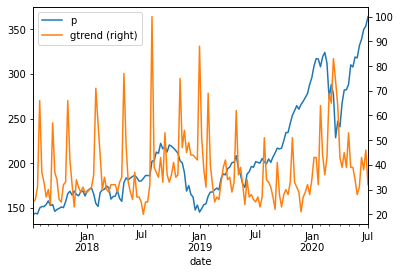

In [7]:
plot_p_gtrend(p, gtrend, nback=52*3)

# 시그널 만들기

In [16]:
buysell = get_buysell(p, gtrend); buysell

date
2016-07-10     N
2016-07-17     N
2016-07-24     N
2016-07-31     B
2016-08-07     B
              ..
2020-06-07    SB
2020-06-14    SB
2020-06-21    SB
2020-06-28    SB
2020-07-05    SB
Freq: W-SUN, Length: 209, dtype: object

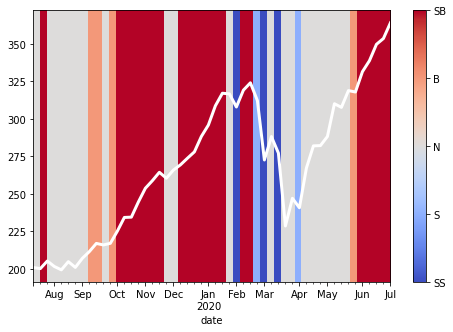

In [18]:
plot_buysell(buysell, p, nback=52)

# 시그널의 유효성

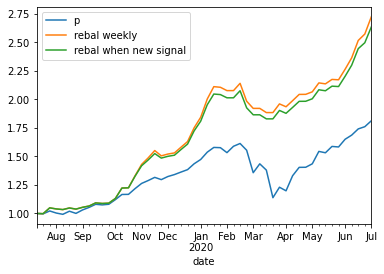

In [19]:
plot_perf(buysell, p, strat={'SS':0, 'S':0.25, 'N':0.5, 'B':1, 'SB':2}, nback=52)

In [20]:
get_hitratio(buysell, p, nback=52)

,buy,sell,buy or sell
strong,0.857143,0.333333,0.791667
normal,0.840000,0.400000,0.766667
